# Pokémon TCG Data Analysis

This notebook explores distributions of card rarities, HP distributions by stage, energy‐cost vs. damage relationships, and pack‐level summaries based on your Pokémon TCG CSV.


In [1]:
# standard imports
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

import colorsys
import networkx as nx

# render plots inline
%matplotlib inline

In [2]:
# Constants for graphs
TYPE_COLOURS = {
    "Colorless": "#D2D0CF",
    "Darkness": "#2E7077",
    "Dragon": "#948F31",
    "Fairy": "#D6457E",
    "Fighting": "#B16232",
    "Fire": "#D8223B",
    "Grass": "#19A648",
    "Lightning": "#FCD021",
    "Metal": "#9B9E8C",
    "Psychic": "#957DAB",
    "Water": "#05A8D9",
}


# Helper functions
def adjust_color(hex_color : str, factor : float) -> str:
    """
    Lightens / darkens a hex color
    
    Parameters
    ----------
        hex_color : str
            The original hex colour (#RRGGBB).
        factor : float
            The scaling factor to lighten / darken the colour.
            factor > 1 lightens, and < 1 darkens
            
    Returns
    -------
        new_colour : str
            The modified hex colour after changing brightness
    """
    rgb = mcolors.to_rgb(hex_color)
    hls = colorsys.rgb_to_hls(*rgb)
    # factor > 1 = lighten, factor < 1 = darken
    new_rgb = colorsys.hls_to_rgb(hls[0], max(0, min(1, hls[1] * factor)), hls[2])
    return mcolors.to_hex(new_rgb)

In [3]:
# load the data
ORIGINAL_DF = pd.read_csv("data/full.csv")

# quick peek
ORIGINAL_DF.head()


,number,name,rarity,stage,HP,type,weakness,retreat_cost,ultra_beast,generation,...,move1_name,move1_cost,move1_damage,move1_effect,move2_name,move2_cost,move2_damage,move2_effect,image,url
0,A1 001,Bulbasaur,◇,Basic,70.0,Grass,Fire,1.0,No,1,...,Vine Whip,🟢*️⃣,40,NaN,NaN,NaN,NaN,NaN,https://img.game8.co/3998332/91c4f79b2b3b42062...,https://game8.co/games/Pokemon-TCG-Pocket/arch...
1,A1 002,Ivysaur,◇◇,Stage 1,90.0,Grass,Fire,2.0,No,1,...,Razor Leaf,🟢*️⃣*️⃣,40,NaN,NaN,NaN,NaN,NaN,https://img.game8.co/4006820/34e0ae3e3a08bf458...,https://game8.co/games/Pokemon-TCG-Pocket/arch...
2,A1 003,Venusaur,◇◇◇,Stage 2,160.0,Grass,Fire,3.0,No,1,...,Mega Drain,🟢🟢*️⃣*️⃣,80,Heal 30 damage from this Pokemon.,NaN,NaN,NaN,NaN,https://img.game8.co/4003548/e62b9303f29d5360a...,https://game8.co/games/Pokemon-TCG-Pocket/arch...
3,A1 004,Venusaur ex,◇◇◇◇,Stage 2,190.0,Grass,Fire,3.0,No,1,...,Razor Leaf,🟢*️⃣*️⃣,60,NaN,Giant Bloom,🟢🟢*️⃣*️⃣,100,Heal 30 damage from this Pokemon.,https://img.game8.co/3995580/151d2c9455f838996...,https://game8.co/games/Pokemon-TCG-Pocket/arch...
4,A1 005,Caterpie,◇,Basic,50.0,Grass,Fire,1.0,No,1,...,Find a Friend,*️⃣,NaN,Put 1 random Grass Pokemon from your deck into...,NaN,NaN,NaN,NaN,https://img.game8.co/4004054/ac3d9d05b0255de5e...,https://game8.co/games/Pokemon-TCG-Pocket/arch...


## 1. Rarity Distribution

Count how many cards of each rarity (◇, ◇◇, ◇◇◇, ☆☆, etc.) there are


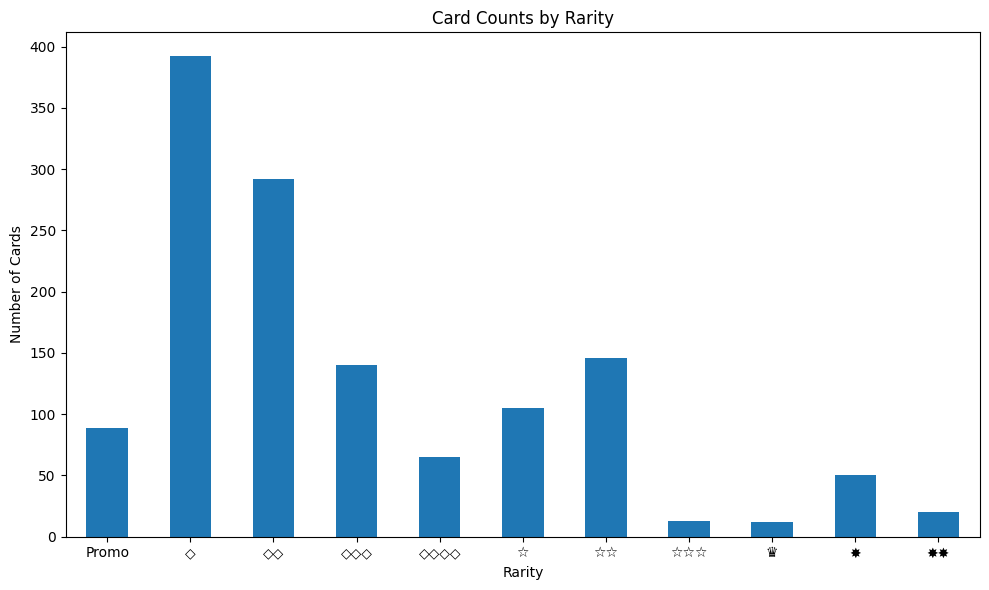

In [4]:
df = ORIGINAL_DF.copy()
rarity_counts = df["rarity"].value_counts().sort_index()

plt.figure(figsize=(10,6))
rarity_counts.plot(kind="bar")
plt.title("Card Counts by Rarity")
plt.xlabel("Rarity")
plt.ylabel("Number of Cards")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 2. Type Distribution

Count how many cards of each type (Water, Fire, Metal, etc.) there are

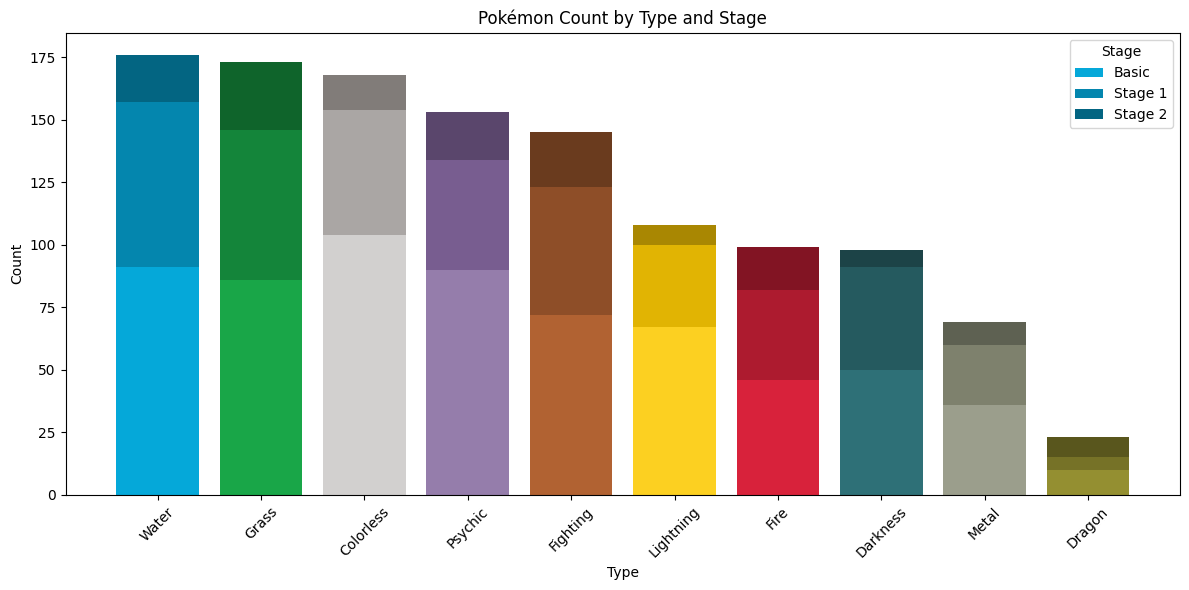

In [5]:
df = ORIGINAL_DF.copy()

# Group and order
stages = ["Basic", "Stage 1", "Stage 2"]
grouped = df.groupby(["type", "stage"]).size().unstack(fill_value=0)
grouped = grouped[stages]
grouped = grouped.loc[grouped.sum(axis=1).sort_values(ascending=False).index]

# Plot manually using matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

bottom = [0] * len(grouped)
x_retreat = range(len(grouped))
bar_width = 0.8

for stage, factor in zip(stages, [1.0, 0.8, 0.6]):
    values = grouped[stage].values
    colors = [adjust_color(TYPE_COLOURS.get(t, "#A0A0A0"), factor) for t in grouped.index]
    ax.bar(x_retreat, values, bottom=bottom, label=stage, color=colors, width=bar_width)
    bottom = [b + v for b, v in zip(bottom, values)]

# Labels and formatting
ax.set_xticks(x_retreat)
ax.set_xticklabels(grouped.index, rotation=45)
ax.set_xlabel("Type")
ax.set_ylabel("Count")
ax.set_title("Pokémon Count by Type and Stage")
ax.legend(title="Stage")
plt.tight_layout()
plt.show()

## 3. Pack Distribution

Count how many cards of each pack (A1 Pikachu, A2 Any, Promo Promo-A, etc.) there are

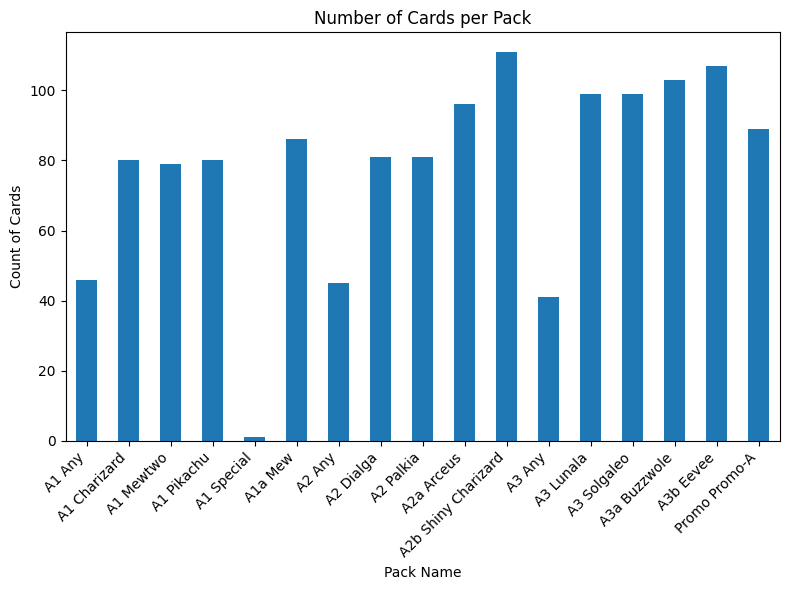

In [6]:
df = ORIGINAL_DF.copy()
df["pack_name"] = df["pack_name"].apply(
    lambda s: s.split("(")[-1].replace(")", ""))
pack_counts = df["pack_name"].value_counts().sort_index()

plt.figure(figsize=(8, 6))
pack_counts.plot(kind="bar")
plt.title("Number of Cards per Pack")
plt.xlabel("Pack Name")
plt.ylabel("Count of Cards")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 4. Move 1 Energy Cost vs. Damage

Scatterplot and regression of relationship between move cost and damage

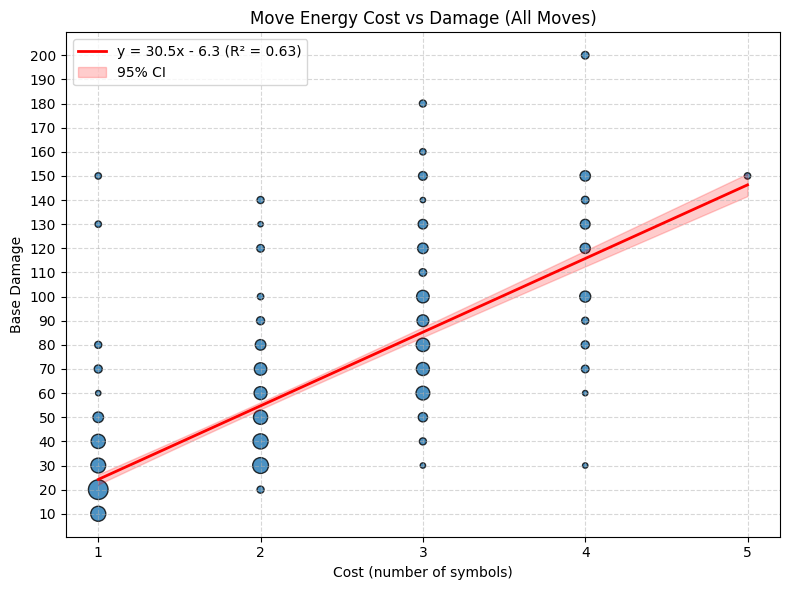

In [7]:
df = ORIGINAL_DF.copy()

# Clean move1 data
df["move1_cost"] = df["move1_cost"].str.replace("*️⃣", "*", regex=False)
df["move1_cost_count"] = df["move1_cost"].fillna("").str.len()
df["move1_damage"] = pd.to_numeric(df["move1_damage"], errors="coerce")

# Clean move2 data
df["move2_cost"] = df["move2_cost"].str.replace("*️⃣", "*", regex=False)
df["move2_cost_count"] = df["move2_cost"].fillna("").str.len()
df["move2_damage"] = pd.to_numeric(df["move2_damage"], errors="coerce")

# Create DataFrames for move1 and move2
move1_df = (
    df[["move1_cost_count", "move1_damage"]]
    .dropna()
    .rename(columns={"move1_cost_count": "cost", "move1_damage": "damage"})
)
move2_df = (
    df[["move2_cost_count", "move2_damage"]]
    .dropna()
    .rename(columns={"move2_cost_count": "cost", "move2_damage": "damage"})
)

# Concatenate both
combined_df = pd.concat([move1_df, move2_df], ignore_index=True)

# Group and count duplicates
freq_df = combined_df.groupby(["cost", "damage"]).size().reset_index(name="count")

# Raw data for regression
x_retreat = combined_df["cost"]
y_HP = combined_df["damage"]

# Linear regression
β1, β0, r_value, p_value, std_err = stats.linregress(x_retreat, y_HP)
r_squared = r_value**2

# Regression line
x_retreat_line = np.linspace(x_retreat.min(), x_retreat.max(), 100)
y_HP_line = β0 + β1 * x_retreat_line

# Confidence bands (95%)
n = len(x_retreat)
y_pred = β1 * x_retreat + β0
residuals = y_HP - y_pred
dof = n - 2
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

# 1.96 = 95% confidence for normal dist
mean_x = np.mean(x_retreat)
sxx = np.sum((x_retreat - mean_x) ** 2)  # Sum of squares of x
standard_error = residual_std_error * np.sqrt(1 / n + (x_retreat_line - mean_x) ** 2 / sxx)
z_score = 1.96  # for 95% confidence

ci = z_score * standard_error
lower = y_HP_line - ci
upper = y_HP_line + ci

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    freq_df["cost"],
    freq_df["damage"],
    s=np.sqrt(freq_df["count"]) * 15,  # scale size for visibility
    alpha=0.8,
    edgecolors="k",
)

# Plot regression line
label = f"y = {β1:.1f}x {'-' if β0 < 0 else '+'} {abs(β0):.1f} (R² = {r_squared:.2f})"
plt.plot(x_retreat_line, y_HP_line, color="red", linewidth=2, label=label)
# Confidence band
plt.fill_between(x_retreat_line, lower, upper, color="red", alpha=0.2, label="95% CI")

# Integer x-axis ticks
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
# Jump by 10 y-axis ticks
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(10))

# Labels and grid
plt.title("Move Energy Cost vs Damage (All Moves)")
plt.xlabel("Cost (number of symbols)")
plt.ylabel("Base Damage")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 4.5 Retreat cost vs. HP

Scatterplot and regression of relationship between move retreat cost and HP

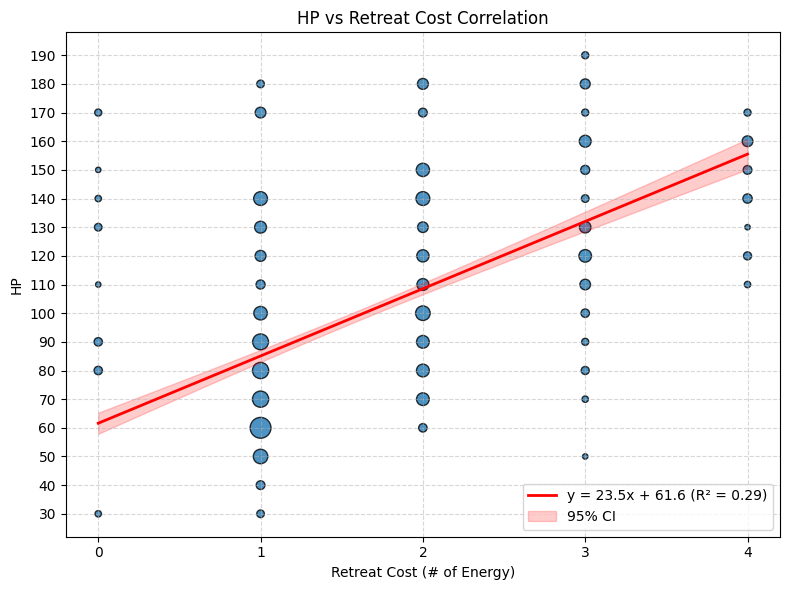

In [8]:
df = ORIGINAL_DF.copy()

# Group and count duplicates
freq_df = df.groupby(["retreat_cost", "HP"]).size().reset_index(name="count")

# Raw data for regression
x_retreat = df["retreat_cost"].dropna()
y_HP = df["HP"].dropna()

# Linear regression
β1, β0, r_value, p_value, std_err = stats.linregress(x_retreat, y_HP)
r_squared = r_value**2

# Regression line
x_retreat_line = np.linspace(x_retreat.min(), x_retreat.max(), 100)
y_HP_line = β0 + β1 * x_retreat_line

# Confidence bands (95%)
n = len(x_retreat)
y_pred = β1 * x_retreat + β0
residuals = y_HP - y_pred
dof = n - 2
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

# 1.96 = 95% confidence for normal dist
mean_x = np.mean(x_retreat)
sxx = np.sum((x_retreat - mean_x) ** 2)  # Sum of squares of x
standard_error = residual_std_error * np.sqrt(1 / n + (x_retreat_line - mean_x) ** 2 / sxx)
z_score = 1.96  # for 95% confidence

ci = z_score * standard_error
lower = y_HP_line - ci
upper = y_HP_line + ci

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    freq_df["retreat_cost"],
    freq_df["HP"],
    s=np.sqrt(freq_df["count"]) * 15,  # scale size for visibility
    alpha=0.8,
    edgecolors="k",
)

# Plot regression line
label = f"y = {β1:.1f}x {'-' if β0 < 0 else '+'} {abs(β0):.1f} (R² = {r_squared:.2f})"
plt.plot(x_retreat_line, y_HP_line, color="red", linewidth=2, label=label)
# Confidence band
plt.fill_between(x_retreat_line, lower, upper, color="red", alpha=0.2, label="95% CI")

# Integer x-axis ticks
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
# Jump by 10 y-axis ticks
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(10))

# Labels and grid
plt.title("HP vs Retreat Cost Correlation")
plt.xlabel("Retreat Cost (# of Energy)")
plt.ylabel("HP")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Type Weakness Graph

In [9]:
df = ORIGINAL_DF.copy()

# Drop rows with missing values
df = df.dropna(subset=["weakness", "type"])

# Keep only types and weakness' if they are valid pokemon types
df = df[df["weakness"].isin(TYPE_COLOURS.keys()) & df["type"].isin(TYPE_COLOURS.keys())]

# Group and count occurrences
edge_counts = (
    df.groupby(["weakness", "type"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print(edge_counts)

     weakness       type  count
4        Fire      Grass    168
16  Lightning      Water    143
1    Fighting  Colorless    119
0    Darkness    Psychic    114
3    Fighting  Lightning    103
20      Water       Fire     91
7       Grass   Fighting     80
5        Fire      Metal     67
2    Fighting   Darkness     61
19    Psychic   Fighting     61
8   Lightning  Colorless     49
17      Metal    Psychic     36
6       Grass   Darkness     35
18      Metal      Water     33
11  Lightning       Fire      8
12  Lightning      Grass      5
13  Lightning  Lightning      5
10  Lightning   Fighting      4
15  Lightning    Psychic      3
9   Lightning   Darkness      2
14  Lightning      Metal      2


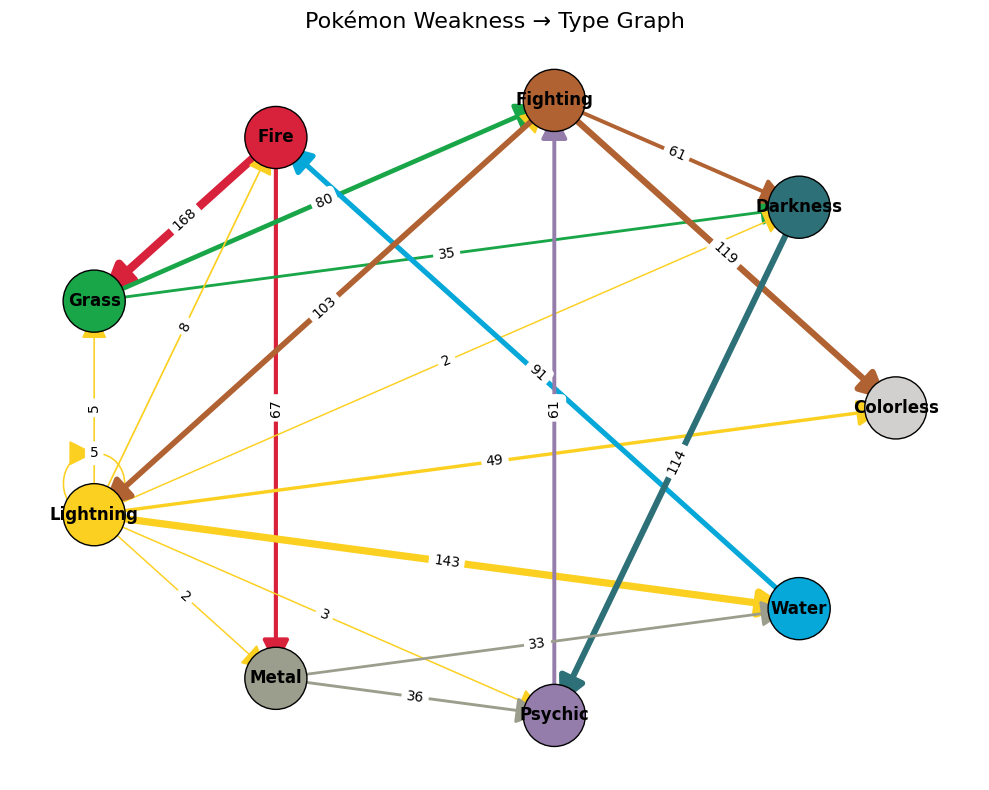

In [10]:
# Build directed graph
G = nx.DiGraph()
for _, row in edge_counts.iterrows():
    G.add_edge(row["weakness"], row["type"], weight=row["count"])

# Compute net flow score = outdegree - indegree
node_scores = {node: G.out_degree(node) - G.in_degree(node) for node in G.nodes()}
sorted_nodes = sorted(node_scores, key=node_scores.get, reverse=True)

# Regular n-gon arrangement
unique_types = sorted(set(edge_counts["weakness"]).union(set(edge_counts["type"])))
def regular_polygon_layout(nodes, radius=5):
    layout = {}
    n = len(nodes)
    for i, node in enumerate(nodes):
        angle = 2 * np.pi * i / n
        layout[node] = (radius * np.cos(angle), radius * np.sin(angle))
    return layout

# Custom layout: x by order, y by score
def score_layout(sorted_nodes, scores, x_spacing=2.5, y_scale=1.0):
    layout = {}
    for i, node in enumerate(sorted_nodes):
        layout[node] = (-i * x_spacing, scores[node] * y_scale)  # flipped x to have "strong" on left
    return layout

# pos = score_layout(sorted_nodes, node_scores)
pos = regular_polygon_layout(unique_types)

# Normalize weights for edge width
weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(weights)
scaled_weights = [1 + 5 * (w / max_weight) for w in weights]

# Node and edge colors
node_colors = [TYPE_COLOURS.get(n, "#A0A0A0") for n in G.nodes()]
edge_colors = [TYPE_COLOURS.get(u, "#A0A0A0") for u, v in G.edges()]

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
nx.draw_networkx_edges(
    G, pos, width=scaled_weights, edge_color=edge_colors, arrowstyle="-|>", arrowsize=40
)
edge_labels = {(u, v): G[u][v]["weight"] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Pokémon Weakness → Type Graph", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

## 6. HP Violin Plot

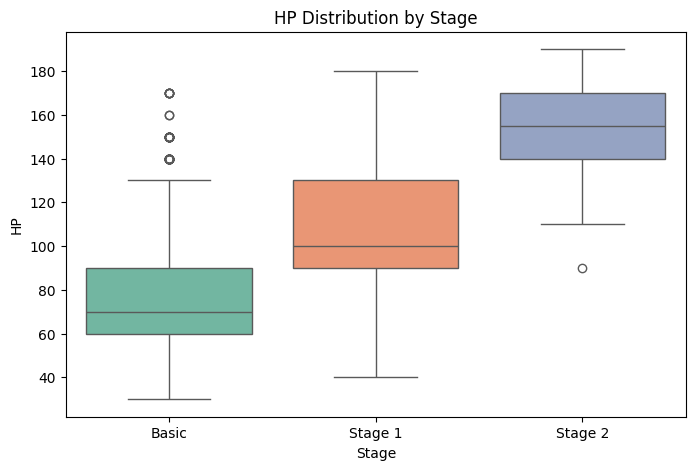

In [11]:
df = ORIGINAL_DF.copy()
# Convert HP to numeric (some may be missing or malformed)
df['HP'] = pd.to_numeric(df['HP'], errors='coerce')

# Boxplot of HP by stage
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='stage', hue='stage', y='HP', palette='Set2', legend=False)
plt.title('HP Distribution by Stage')
plt.ylabel('HP')
plt.xlabel('Stage')
plt.show()

## 7. Top Illustrators

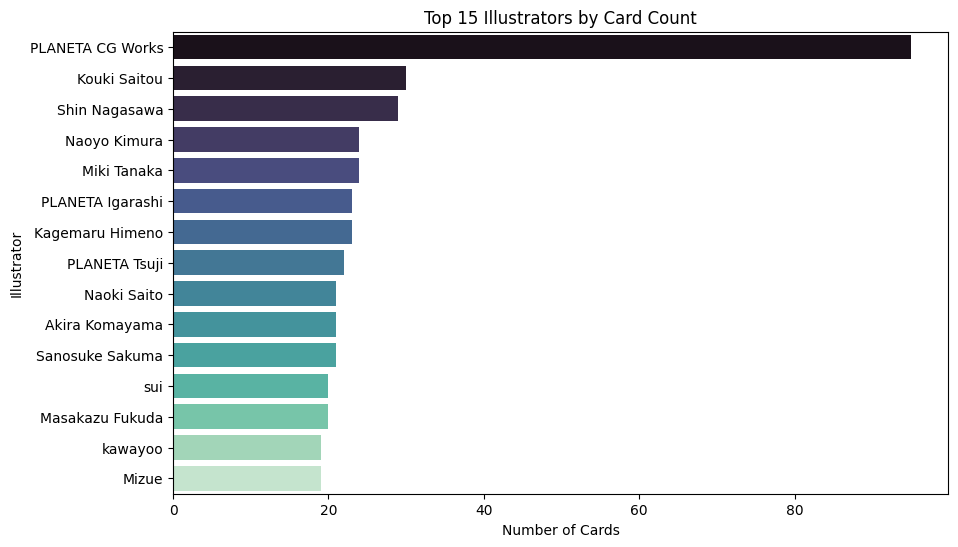

In [12]:
df = ORIGINAL_DF.copy()
# Count number of cards per illustrator
top_illustrators = df['illustrator'].value_counts().head(15)

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_illustrators.values, y=top_illustrators.index,
            hue=top_illustrators.index, palette='mako', legend=False)
plt.title('Top 15 Illustrators by Card Count')
plt.xlabel('Number of Cards')
plt.ylabel('Illustrator')
plt.show()

## 8. Bubble

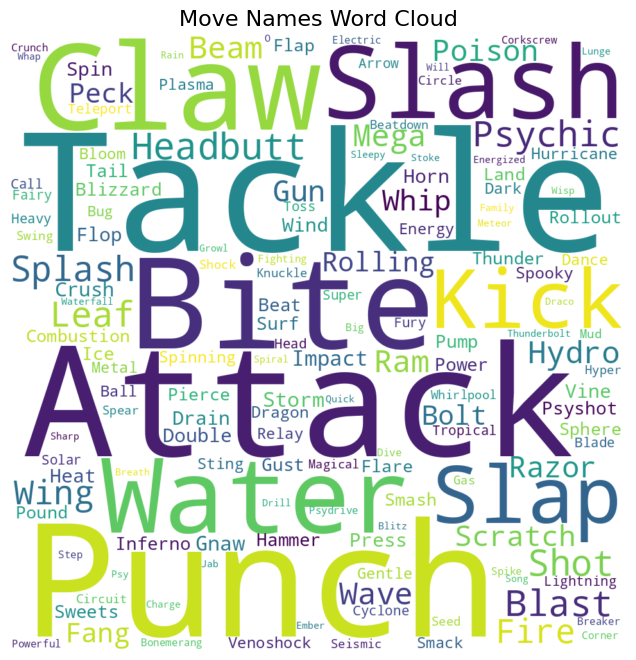

In [13]:
df = ORIGINAL_DF.copy()
# Combine move names
text = ' '.join(df['move1_name'].dropna().astype(str)) + ' ' + \
       ' '.join(df['move2_name'].dropna().astype(str))

# Create WordCloud object with upright text and bubble-like shape
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    prefer_horizontal=1.0,
    collocations=False,
    contour_color='lightblue',
    contour_width=2,
    scale=1.2,
    relative_scaling=0.5,
    max_words=150
).generate(text)

# Display
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Move Names Word Cloud', fontsize=16)
plt.show()

## 9. Word Graph

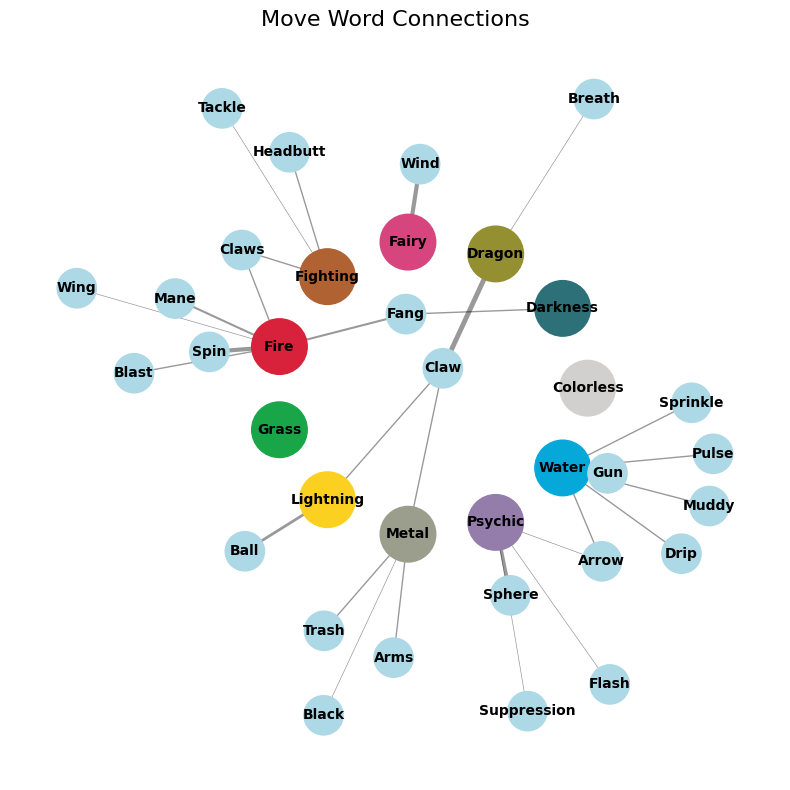

In [14]:
df = ORIGINAL_DF.copy()
# Step 1: Collect all move names
all_moves = pd.concat([df['move1_name'], df['move2_name']]).dropna().astype(str)
type_names = TYPE_COLOURS.keys()

# Step 2: Build graph with highlighted anchors
G = nx.Graph()
G.add_nodes_from(type_names)

for move in all_moves:
    words = move.split()
    for anchor in type_names:
        if anchor in words:
            for word in words:
                if word != anchor:
                    if G.has_edge(anchor, word):
                        G[anchor][word]['weight'] += 1
                    else:
                        G.add_edge(anchor, word, weight=1)

# Step 3: Layout with anchor nodes fixed in a triangle
angle_step = 2 * np.pi / len(type_names)
fixed_pos = {
    word: (np.cos(i * angle_step), np.sin(i * angle_step))
    for i, word in enumerate(type_names)
}
pos = nx.spring_layout(G, pos=fixed_pos, fixed=type_names, k=0.5, iterations=100, seed=42)

# Step 4: Drawing
plt.figure(figsize=(8, 8))

node_colors = [
    TYPE_COLOURS.get(node, "lightblue")
    for node in G.nodes
]
node_sizes = [1600 if node in type_names else 800 for node in G.nodes]
edge_widths = [G[u][v]['weight'] * 0.5 for u, v in G.edges]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Move Word Connections", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()